# 3 Statistical inference and Maximum Likelihood

 $\large P.D.F.: P_\lambda(X) = \Large\frac{e^{-x/\lambda}}{\lambda Z(\lambda)} \large \qquad   for  \qquad  x\in[1,20], \qquad 0 \qquad otherwise$  

1.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def Z(lam): #partition function
    return np.exp(-1/lam)-np.exp(-(20/lam))

def Z_1d(lam):
    return (1/(lam**2))*(np.exp(-1/lam) - 20*np.exp(-20/lam))

def Z_2d(lam):
    return (1/(lam**4))*((1-2*lam)*np.exp(-1/lam) - 40*(10-lam)*np.exp(-20/lam))


def random(lam): #random generator with the wanted exponential distribution
    return -lam*np.log(np.exp(-1/lam)-np.random.uniform(0,1)*Z(lam))

#we define here the function that generate the sampling of N events 
def simulate(N,lam,dx,x_min,x_max):
    x1 = np.arange(x_min,x_max,dx)
    sample=np.empty(N)
    histo=np.zeros(int((x_max-x_min)/dx))
    for i in range(N):
        y=random(lam)
        sample[i]=y
        histo[int(((y-x_min)/dx)-1)]+=1
    return sample,histo

def P_lambda(x,lamb,dx):
    return np.exp(-x/lamb)/(lamb*Z(lamb))    #####NON CI ANDAVA dx FORSE   #return np.exp(-x/lamb)*dx/(lamb*Z(lamb))

def loglike(l,sample):
    return np.sum(np.log([(P_lambda(sample[i],l,dx)) for i in range(len(sample))]))


2.

In [ ]:
x_min = 0.0
x_max = 25.0
l_min=3 #we start from here in order to hava a better plot, but it works anyway
l_max=20
dl=0.1
dx = 0.1

x1 = np.arange(x_min,x_max,dx)
lam = 10.0

for j in range(3):
    N=10**(j+1)
    sam,histo=simulate(N,lam,dx,x_min,x_max)
    lam_space=np.arange(l_min,l_max,dl)           
    log_L=[(loglike(lam_space[i],sam)) for i in range(len(lam_space))]
    max_lam=(np.argmax(log_L)+1)*dl+l_min
    
    plt.figure(figsize=(10,5));
    plt.plot(x1,histo,'bo',markersize=3);
    plt.title('N= %i'  %N,fontsize=15)
    plt.xticks(np.arange(0,25,1))
    plt.show;
    
    plt.figure(figsize=(10,5))
    #plt.plot(lam_space,like,label='L')
    plt.plot(lam_space,log_L,label='logL')
    plt.title('$\widehat{\lambda}_{ML}= $'+str(max_lam), loc='right',fontsize=15)
    #plt.legend()
    plt.axvline(x=max_lam,linestyle='--')
    plt.axvline(x=lam,color='r',label='correct')
    plt.show()
    plt.close()

3.

8.306475162506104


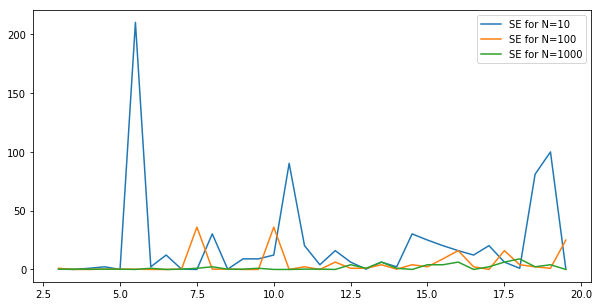

In [2]:
from joblib import Parallel, delayed
import multiprocessing

cores=multiprocessing.cpu_count()
import time



#array containing the possible values for lambda
x_min = 0.0
x_max = 25.0
l_min=3 #we start from here in order to hava a better plot, but it works anyway
l_max=20
dl=0.5
dx = 0.1
lam_sp=np.arange(l_min,l_max,dl)

start = time.time()

plt.figure(figsize=(10,5))
for i in range(3):
    N=10**(i+1)
    max_lam=np.zeros(len(lam_sp))
    for k in range(len(lam_sp)):
        sam=simulate(N,lam_sp[k],dx,x_min,x_max)[0] 
        log_L=Parallel(n_jobs=cores)(delayed(loglike)(lam_sp[j],sam)for j in range(len(lam_sp)))
        max_lam[k]=(np.argmax(log_L)+1)*dl+l_min
        
        
    squared_error=np.power(max_lam-lam_sp,2)
    plt.plot(lam_sp,squared_error, label="SE for N="+str(N))
    plt.legend()
    
end = time.time()
print(end - start)

4.

In [ ]:

def exp_val(lam):#expected value using our pdf
    return lam + (np.exp(19/lam)-20)/(np.exp(19/lam)-1)

N=10

x_min = 0.0
x_max = 25.0
l_min=1 #we start from here in order to hava a better plot, but it works anyway
l_max=20
dl=0.1
dx = 0.1
lam_sp=np.arange(l_min,l_max,dl)


from joblib import Parallel, delayed
import multiprocessing
cores=multiprocessing.cpu_count()

import time
start = time.time()


reals=1000 #realizations
mean_squared_error=[]
fisher=[]
cramer_rao=[]

for k in range(len(lam_sp)):
    squared_error=np.zeros(reals)
    max_lam=np.zeros(reals)
    for i in range(reals):
        sam=simulate(N,lam_sp[k],dx,x_min,x_max)[0]
        log_L=Parallel(n_jobs=cores)(delayed(loglike)(lam_sp[j],sam)for j in range(len(lam_sp)))
        max_lam[i]=(np.argmax(log_L)+1)*dl+l_min
        
    squared_error=Parallel(n_jobs=cores)(delayed(np.power)(max_lam[j]-lam_sp[k],2) for j in range(reals))
    c = reals*((Z(lam_sp[k])*Z_2d(lam_sp[k]) - (Z_1d(lam_sp[k])**2)) / (Z(lam_sp[k])**2))
    fisher.append(reals*(2*exp_val(lam_sp[k]))/(lam_sp[k]**3)-reals/(lam_sp[k]**2)+c)
    cramer_rao.append(1/fisher[k])
    
    mean_squared_error.append(sum(squared_error)/reals)
    
plt.plot(lam_sp,mean_squared_error, label="MSE for N="+str(N))
plt.plot(lam_sp,cramer_rao, label="Cramers-Rao bound")
#plt.yticks()
plt.legend()

end = time.time()
print(end - start)



#possiamo trovare da teoria la varianza e vedere